In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [4]:
import openaq
api = openaq.OpenAQ()

In [23]:
from shapely.geometry import Polygon, Point
import folium

In [14]:
import requests

In [40]:
import seaborn as sns

In [5]:
from datetime import datetime, timedelta
dt_past_24_hours = (datetime.now() - timedelta(hours = 24)).strftime("%Y-%m-%d %H:%M:%S")
dt_past_24_hours

'2022-10-07 08:52:21'

In [6]:
# get stations in delhi
pollution_stations = api.locations(city='Delhi', df=True, limit=1000)[['location', 'lastUpdated', 'coordinates.latitude', 'coordinates.longitude']]
pollution_stations = pollution_stations.drop_duplicates().rename(columns = {'coordinates.latitude' : 'latitude', 'coordinates.longitude' : 'longitude'})
pollution_stations = pollution_stations.dropna()
pollution_stations

,location,lastUpdated,latitude,longitude
0,US Diplomatic Post: New Delhi,2022-10-08 02:30:00+00:00,28.635760,77.224450
1,"CRRI Mathura Road, Delhi - IMD",2022-10-08 02:15:00+00:00,28.551201,77.273574
2,"Lodhi Road, Delhi - IMD",2022-10-08 02:15:00+00:00,28.591825,77.227307
3,"North Campus, DU, Delhi - IMD",2022-10-08 02:00:00+00:00,28.657381,77.158545
4,"Shadipur, Delhi - CPCB",2022-10-08 02:00:00+00:00,28.651478,77.147311
...,...,...,...,...
113,"Anand Vihar, Delhi - DPCC",2018-02-21 21:15:00+00:00,28.650800,77.315200
114,"Mandir Marg, Delhi - DPCC",2018-02-21 21:15:00+00:00,28.634100,77.200500
121,US Diplomatic Post: New Delhi,2016-11-09 16:30:00+00:00,28.598096,77.189066
123,Civil Lines,2015-07-10 08:15:00+00:00,28.678700,77.226200


In [21]:
pollution_stations = pollution_stations[pollution_stations.lastUpdated > dt_past_24_hours]
pollution_stations['points'] = pollution_stations.apply(lambda x :
                                                        Point(x['longitude'], 
                                                              x['latitude']), axis=1)
print(pollution_stations.shape)
pollution_stations.head()

(31, 6)


,location,lastUpdated,latitude,longitude,points,inside_flag
0,US Diplomatic Post: New Delhi,2022-10-08 02:30:00+00:00,28.635760,77.224450,POINT (77.22445 28.63576),True
1,"CRRI Mathura Road, Delhi - IMD",2022-10-08 02:15:00+00:00,28.551201,77.273574,POINT (77.2735737 28.5512005),True
2,"Lodhi Road, Delhi - IMD",2022-10-08 02:15:00+00:00,28.591825,77.227307,POINT (77.2273074 28.5918245),True
3,"North Campus, DU, Delhi - IMD",2022-10-08 02:00:00+00:00,28.657381,77.158545,POINT (77.1585447 28.6573814),True
4,"Shadipur, Delhi - CPCB",2022-10-08 02:00:00+00:00,28.651478,77.147311,POINT (77.1473105 28.6514781),True


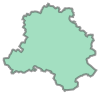

In [15]:
## Lets get boundary of delhi city from OSM and plot it
search_string = 'Delhi'
urlData = requests.get(f'https://nominatim.openstreetmap.org/search.php?q={search_string}&polygon_geojson=1&format=json').json()
bounds = pd.DataFrame.from_dict(urlData)
delhi_boundary = Polygon(bounds[(bounds.type == 'administrative') & (bounds.display_name == 'Delhi, India')].geojson.to_dict()[1]['coordinates'][0])
delhi_boundary

In [28]:
pollution_stations['inside_flag'] = pollution_stations.apply(lambda x: delhi_boundary.contains(Point(x['longitude'],x['latitude'])), axis=1)
pollution_stations = pollution_stations[pollution_stations.inside_flag == True]
print(pollution_stations.shape)
pollution_stations.head()

(31, 7)


,location,lastUpdated,latitude,longitude,points,inside_flag,geometry
0,US Diplomatic Post: New Delhi,2022-10-08 02:30:00+00:00,28.635760,77.224450,POINT (77.22445 28.63576),True,POINT (77.22445 28.63576)
1,"CRRI Mathura Road, Delhi - IMD",2022-10-08 02:15:00+00:00,28.551201,77.273574,POINT (77.2735737 28.5512005),True,POINT (77.27357 28.55120)
2,"Lodhi Road, Delhi - IMD",2022-10-08 02:15:00+00:00,28.591825,77.227307,POINT (77.2273074 28.5918245),True,POINT (77.22731 28.59182)
3,"North Campus, DU, Delhi - IMD",2022-10-08 02:00:00+00:00,28.657381,77.158545,POINT (77.1585447 28.6573814),True,POINT (77.15854 28.65738)
4,"Shadipur, Delhi - CPCB",2022-10-08 02:00:00+00:00,28.651478,77.147311,POINT (77.1473105 28.6514781),True,POINT (77.14731 28.65148)


In [35]:
df_distances = pd.DataFrame()
for i, r in pollution_stations.iterrows():
    distances = pollution_stations['points'].apply(lambda x: r['points'].distance(x))
    distances.index = pollution_stations['location']
    df_distances[r['location']] = distances

In [37]:
df_distances.head()

,US Diplomatic Post: New Delhi,"CRRI Mathura Road, Delhi - IMD","Lodhi Road, Delhi - IMD","North Campus, DU, Delhi - IMD","Shadipur, Delhi - CPCB","IGI Airport (T3), Delhi - IMD","Sirifort, Delhi - CPCB","DTU, Delhi - CPCB","ITO, Delhi - CPCB","Mandir Marg, Delhi - DPCC","Jawaharlal Nehru Stadium, Delhi - DPCC","Mundka, Delhi - DPCC","Punjabi Bagh, Delhi - DPCC","NSIT Dwarka, Delhi - CPCB","Dwarka-Sector 8, Delhi - DPCC","Narela, Delhi - DPCC","Najafgarh, Delhi - DPCC","Major Dhyan Chand National Stadium, Delhi - DPCC","Vivek Vihar, Delhi - DPCC","Sonia Vihar, Delhi - DPCC","Nehru Nagar, Delhi - DPCC","Bawana, Delhi - DPCC","Alipur, Delhi - DPCC","Patparganj, Delhi - DPCC","Wazirpur, Delhi - DPCC","Ashok Vihar, Delhi - DPCC","Sri Aurobindo Marg, Delhi - DPCC","Rohini, Delhi - DPCC","R K Puram, Delhi - DPCC","Jahangirpuri, Delhi - DPCC","Okhla Phase-2, Delhi - DPCC"
location,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
US Diplomatic Post: New Delhi,0.000000,0.097793,0.044028,0.069361,0.078725,0.129062,0.085759,0.160853,0.018078,0.023393,0.056267,0.155757,0.100967,0.193753,0.165716,0.223598,0.297995,0.027853,0.097901,0.078829,0.072703,0.223120,0.193258,0.063895,0.087068,0.073384,0.109902,0.142445,0.081628,0.110982,0.114937
"CRRI Mathura Road, Delhi - IMD",0.097793,0.000000,0.061570,0.156544,0.161239,0.155998,0.057641,0.256683,0.083973,0.111898,0.049247,0.237960,0.188179,0.247887,0.202645,0.321294,0.340341,0.069956,0.128113,0.161118,0.028465,0.316435,0.290344,0.073832,0.183766,0.170983,0.085748,0.237674,0.087472,0.208764,0.020547
"Lodhi Road, Delhi - IMD",0.044028,0.061570,0.000000,0.095005,0.099790,0.113096,0.042932,0.196219,0.039285,0.051751,0.013259,0.177038,0.126613,0.195530,0.156792,0.262817,0.294343,0.022076,0.119242,0.120738,0.033338,0.255054,0.235530,0.067884,0.124431,0.113169,0.070978,0.177001,0.049453,0.151960,0.075214
"North Campus, DU, Delhi - IMD",0.069361,0.156544,0.095005,0.000000,0.012691,0.102925,0.121382,0.104034,0.087383,0.047404,0.107761,0.086396,0.032173,0.134940,0.122328,0.174856,0.241107,0.091634,0.157428,0.105321,0.128325,0.160212,0.158045,0.132984,0.042971,0.044481,0.129939,0.084492,0.098309,0.076401,0.169500
"Shadipur, Delhi - CPCB",0.078725,0.161239,0.099790,0.012691,0.000000,0.093417,0.122153,0.104957,0.096495,0.055823,0.112047,0.078140,0.027831,0.122347,0.110268,0.177252,0.228503,0.098959,0.169240,0.118001,0.132809,0.157534,0.163950,0.142617,0.051609,0.055747,0.127544,0.085553,0.096707,0.084619,0.173000


<AxesSubplot: ylabel='location'>

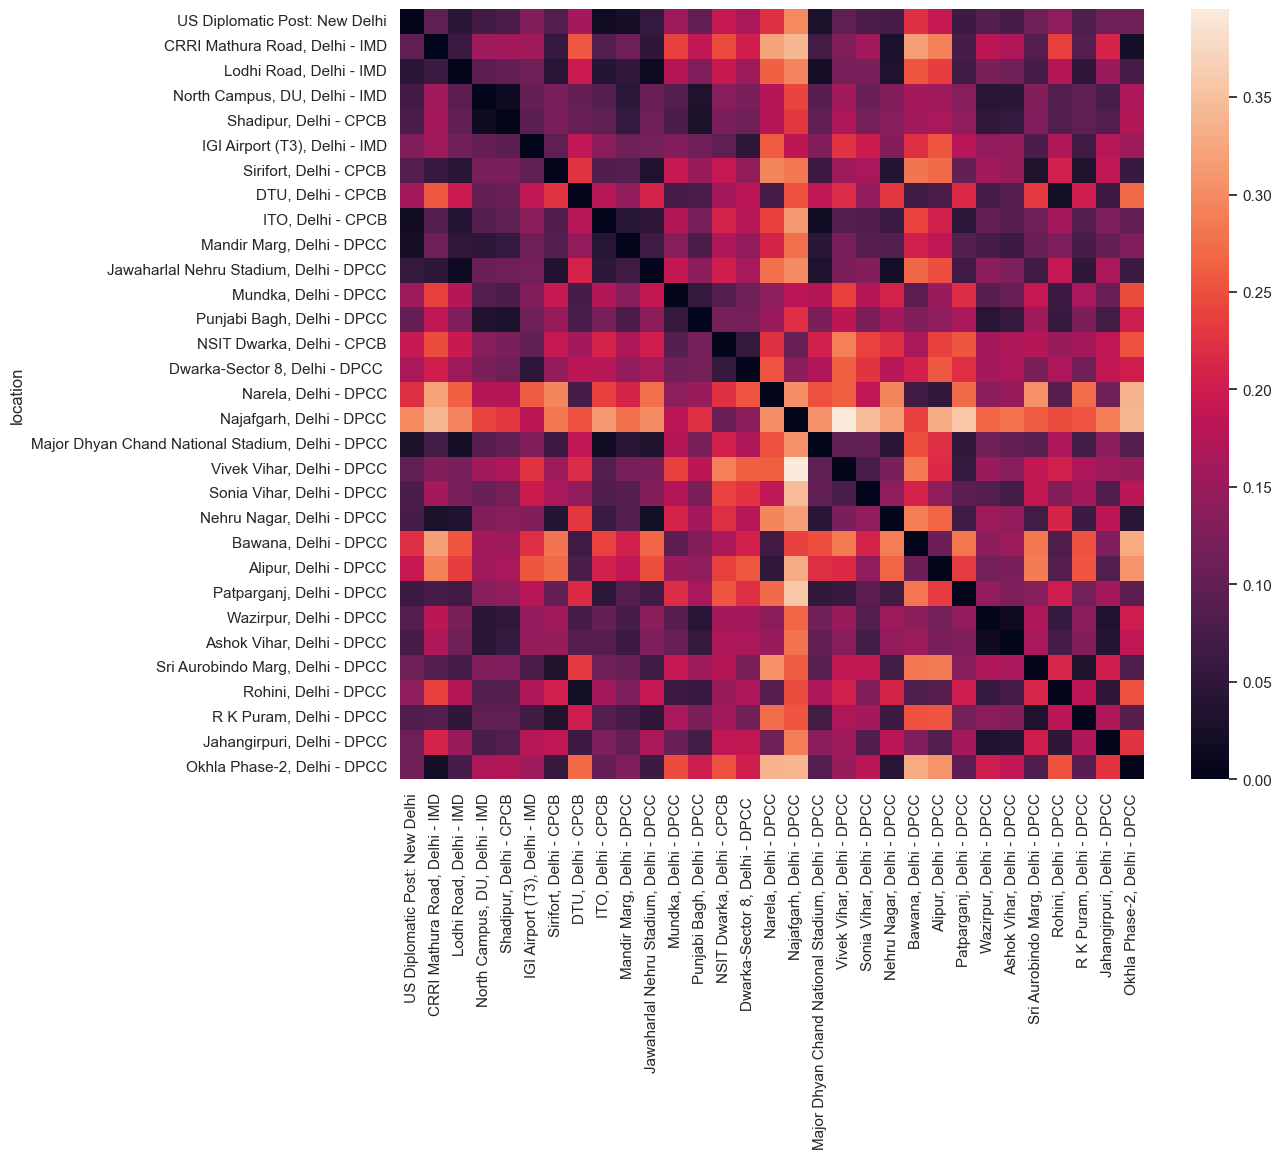

In [46]:
sns.set(rc={'figure.figsize':(12,10)})
sns.heatmap(df_distances, )